In [1]:
# fill namespace with numpy and matplotlib + static notebook plots
%pylab inline
# fill namespace with numpy and matplotlib + and interactive plots
#%pylab notebook 
#%pylab widget
#%matplotlib qt
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.rtlsdr_helper as sdrh
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d
import ipywidgets as widgets
import imp # for module reloading
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX
#Image('fname.png',width='80%')

# RTLSDR Stream Class

Now included in the `rtlsdr_helper` is the `RTLSDR_stream` class. This class contains async methods for reading IQ data from the rtl_sdr, decimating, and playing back audio.

In this notebook only few examples are shown in order to resolve `readthedocs` rendering issues. The omitted live content is placed in markdown cells as *code fences*. In some cases screen shots of plots and GUI controls are provided. To experiment with live code the user can simply move the code in fences back into code cells.

The Python 3.7x asyncio capability is utilized in the software architecture. Being able to function inside the Jupyter event loop is the first hurtle:

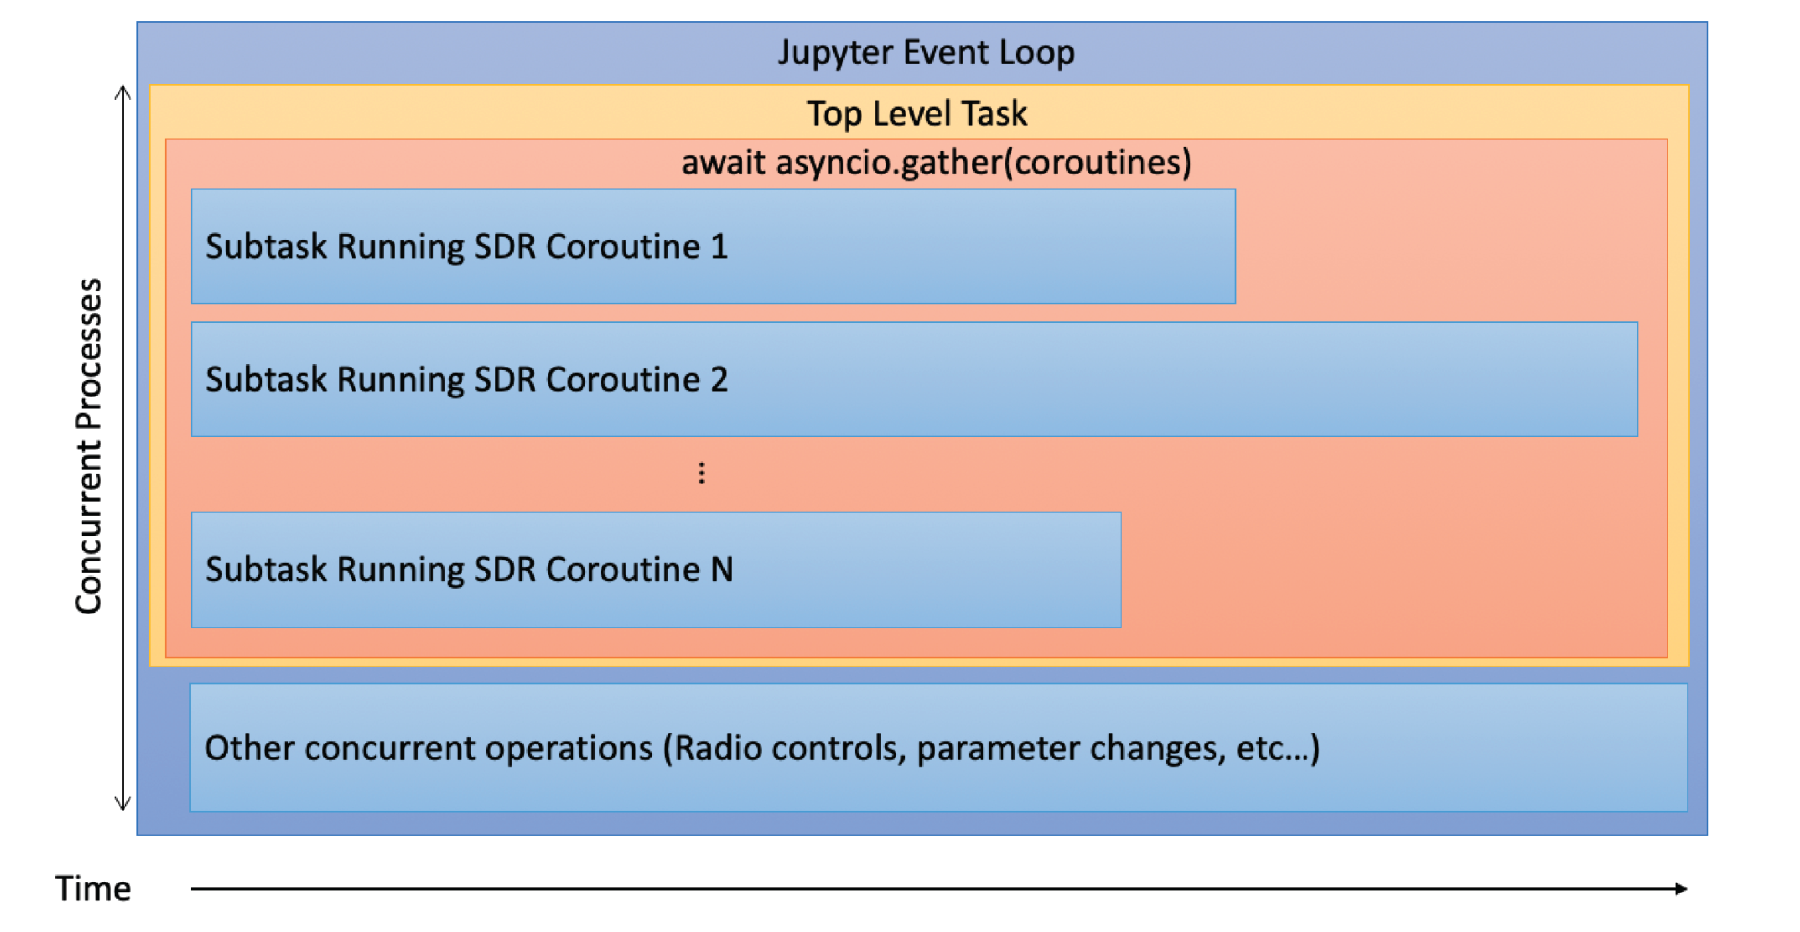

In [9]:
Image("300ppi/Jupyter_concurrent_tasks@300ppi.png", width="90%")

The top level block diagram of the receiver is shown below:

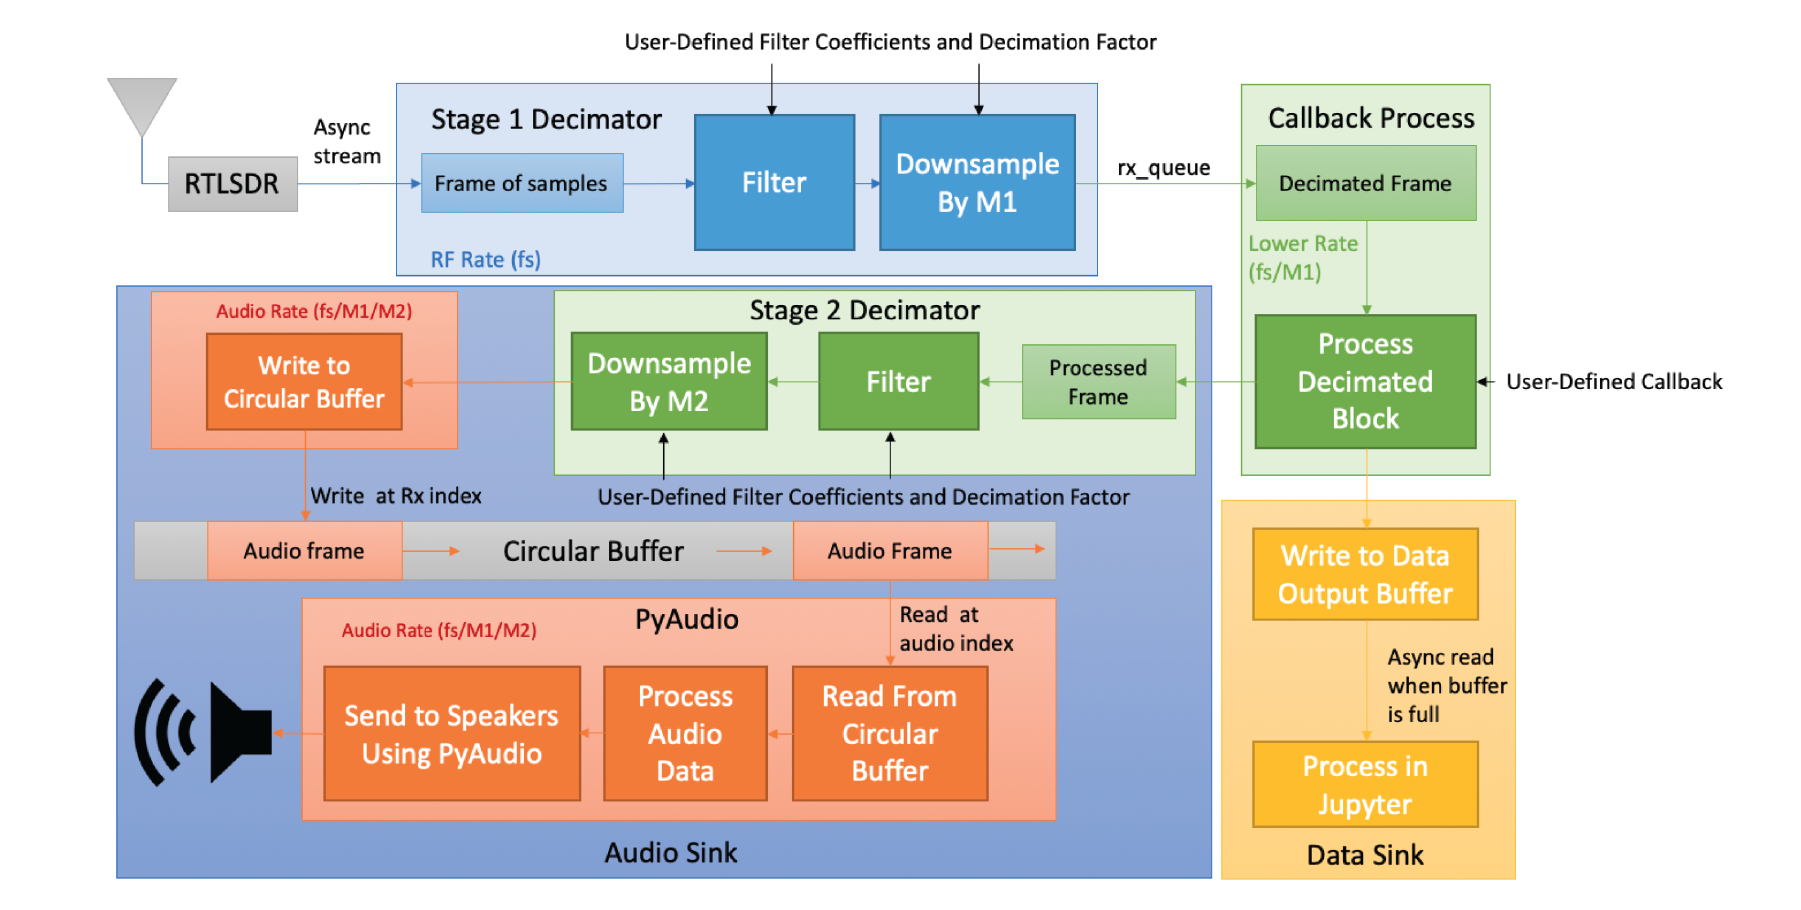

In [10]:
Image("300ppi/RTLSDR_Streaming_Block@300ppi.png", width="90%")

## Mono FM Receiver Example

You can use pyaudio_helper to find available audio devices

In [3]:
sdrh.pah.available_devices()

{0: {'name': 'Built-in Microphone', 'inputs': 2, 'outputs': 0},
 1: {'name': 'Built-in Output', 'inputs': 0, 'outputs': 2}}

In [10]:
sdr_stream = sdrh.RTLSDR_stream(0,rtl_buffer_size=2**15,audio_out=1)

In [11]:
sdr_stream.interactive_FM_Rx(88.7e6,40,1,2048,48000)

Sample Rate: 2400000.0
Center Frequency: 88700000
Gain: 40.2


Output(outputs=({'output_type': 'stream', 'name': 'stdout', 'text': 'Interactive FM Receiver'},))

interactive(children=(ToggleButtons(description=' ', index=1, options=('Start Streaming', 'Stop Streaming'), s…

interactive(children=(FloatSlider(value=0.0, description='Gain (dB)', layout=Layout(width='90%'), max=6.0, min…

interactive(children=(FloatSlider(value=88.7, continuous_update=False, description='$f_c\\;$', layout=Layout(w…

In [12]:
sdr_stream.show_logs()

Output(outputs=({'output_type': 'stream', 'name': 'stdout', 'text': 'LOGS:\n\x1bChanging Center Frequency …

In [7]:
sdr_stream.clear_logs()

In [8]:
sdr_stream.sdr.close()

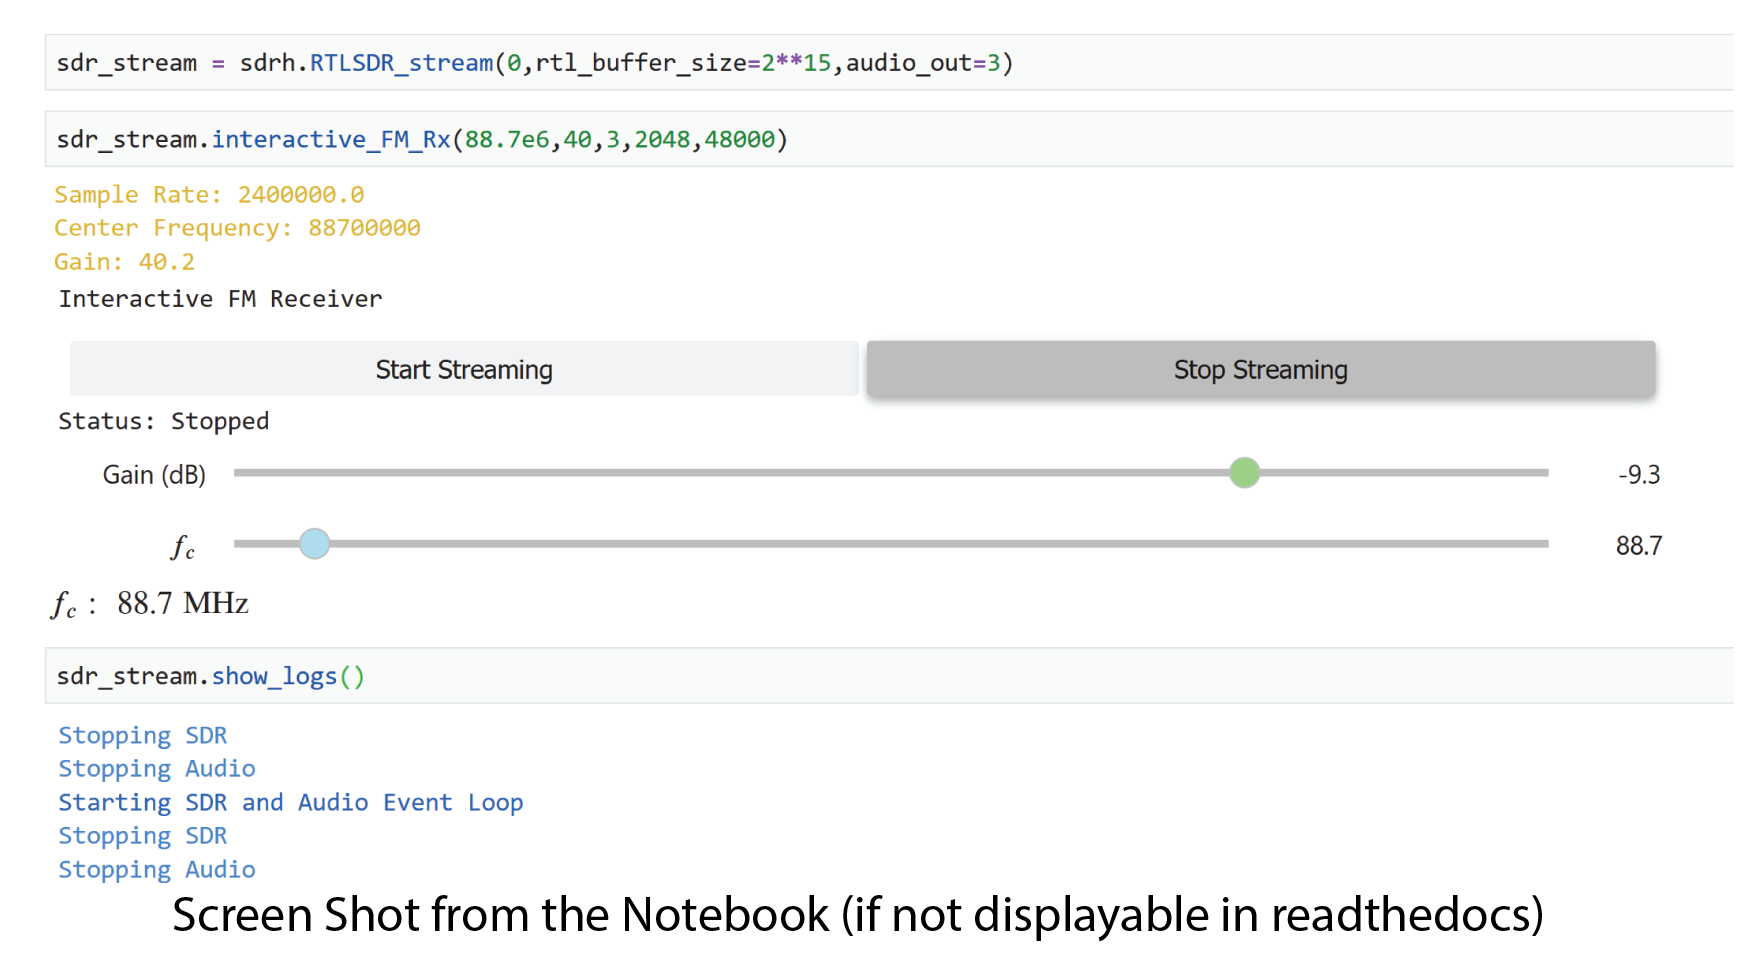

In [3]:
Image("300ppi/Interactive_FM_Rx@300ppi.png", width="90%")

## User-Defined Callbacks

This callback will be called after the initial decimation 

In [9]:
def callback(samples,fs,user_var):
    # Discriminator
    x = samples
    X=np.real(x)                # X is the real part of the received signal
    Y=np.imag(x)                # Y is the imaginary part of the received signal
    b=np.array([1, -1])         # filter coefficients for discrete derivative
    a=np.array([1, 0])          # filter coefficients for discrete derivative
    derY=signal.lfilter(b,a,Y)  # derivative of Y, 
    derX=signal.lfilter(b,a,X)  #    "          X,
    z_bb=(X*derY-Y*derX)/(X**2+Y**2)
    return z_bb,user_var

In [10]:
sdr_stream.run_user_stream(callback,10,5)

Using default stage 1 decimation filter
Using default stage 2 decimation filter
Using default stage 1 initial conditions
Using default stage 2 initial conditions
Starting SDR and Audio Event Loop



In [12]:
sdr_stream.set_audio_gain_db(-20)

In [16]:
sdr_stream.set_fc(88.7e6)

Center Frequency: 88700000


In [17]:
sdr_stream.stop()

# Probing in Time and Frequency
Time and frequency domin probing is possible as depicted in the figure below:

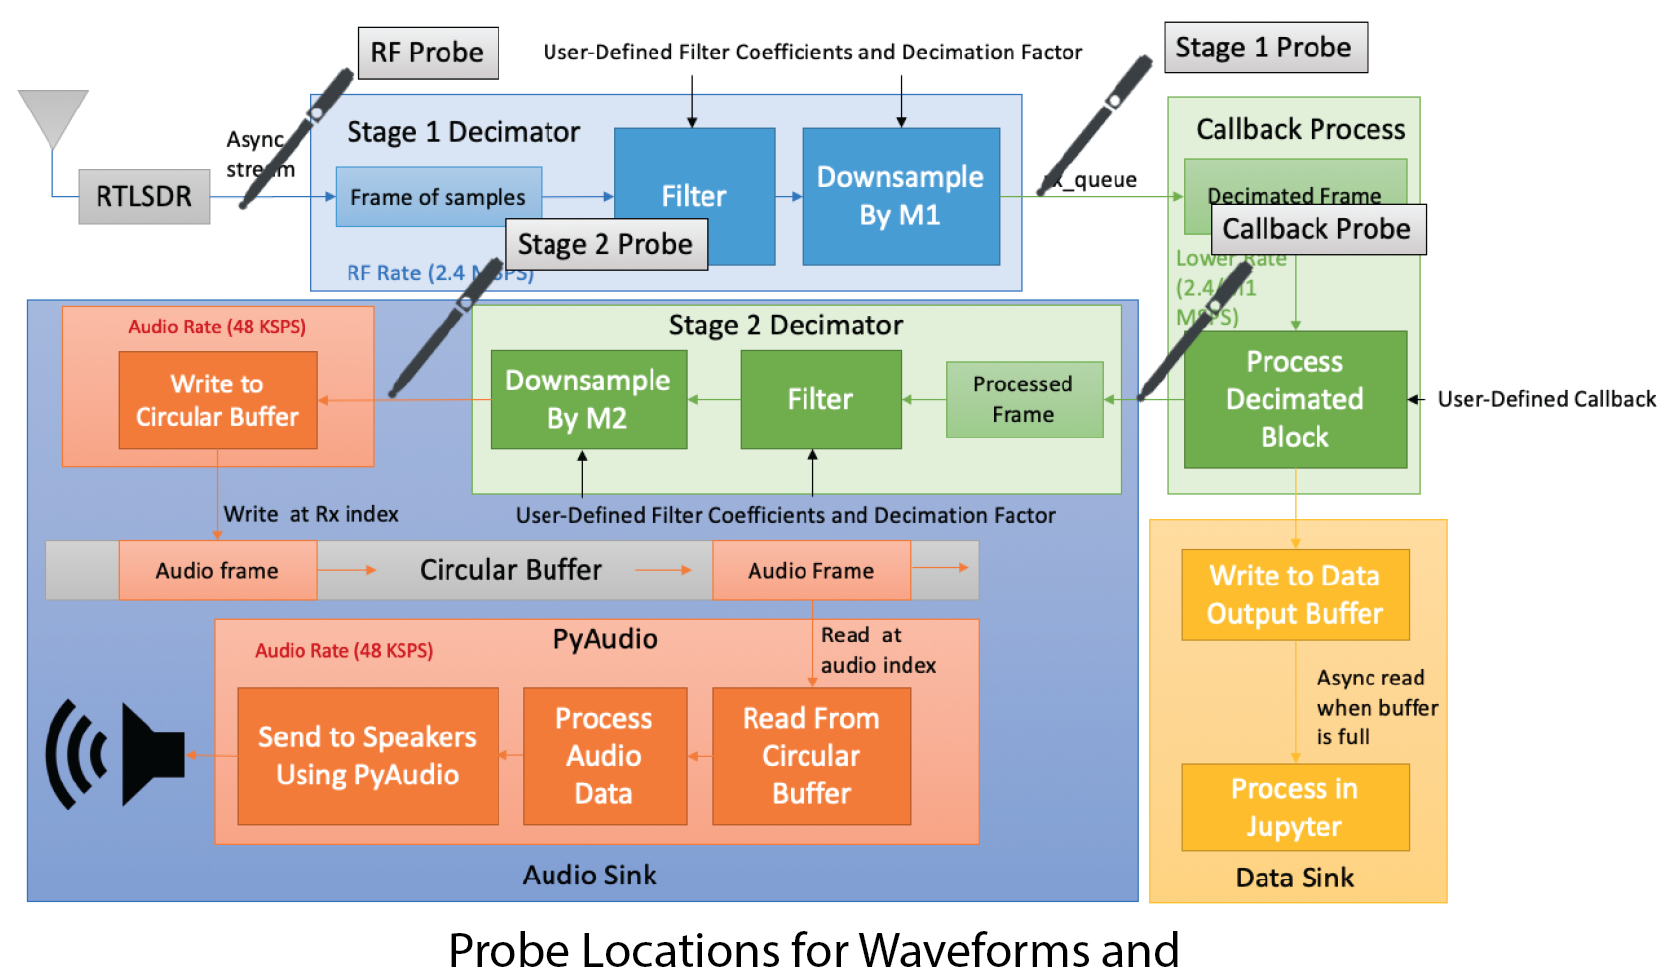

In [4]:
Image("300ppi/Probe_Locations@300ppi.png", width="90%")

## Pulling frames from a stream

```python
sdr_stream.run_user_stream(callback,10,5)

rf_frame = await sdr_stream.get_rf_frame()

Nfft = 2**10
print(len(rf_frame))
Px,f = psd(rf_frame,Nfft,sdr_stream.get_sample_rate()/1e6,sdr_stream.get_center_freq()/1e6);

stage1_frame = await sdr_stream.get_stage1_frame()

print(len(stage1_frame))
psd(stage1_frame,Nfft,2.4e6,99.9e6/10);

processed_stage1_frame = await sdr_stream.get_processed_stage1_frame()

Nfft = 2**10
print(len(processed_stage1_frame))
psd(processed_stage1_frame,Nfft,2.4e6/10,0);

stage2_frame = await sdr_stream.get_stage2_frame()

Nfft = 2**10
print(len(stage2_frame))
psd(stage2_frame,Nfft,2.4e6/50,0);

sdr_stream.stop()
```

## Spectrum Plots
These plots are updated using the `matplotlib` interactive graphics widget: https://github.com/matplotlib/jupyter-matplotlib.

```python
%pylab widget
sdr_stream.set_audio_out(3)

sdr_stream.run_user_stream(callback,10,5)

sdr_stream.run_plot_rf_stream(1024,2,w=15,h=6)

sdr_stream.set_fc(99.9e6)

sdr_stream.set_NFFT(2048)

sdr_stream.set_refresh_rate(4)

sdr_stream.toggle_invert()

sdr_stream.stop_rf_plot()

sdr_stream.run_plot_stage1_stream(1024,1,w=15,h=6)

sdr_stream.stop_stage1_plot()

sdr_stream.run_plot_processed_stage1_stream(1024,1,w=15,h=6)

sdr_stream.stop_processed_stage1_plot()

sdr_stream.run_plot_stage2_stream(1024,1,w=15,h=6)

sdr_stream.set_fc(99.9e6)

sdr_stream.set_refresh_rate(4)

sdr_stream.stop_stage2_plot()

sdr_stream.stop_all()
```

## Using Widgets

```python
import ipywidgets as widgets
```

In [ ]:
import ipywidgets as widgets

### Frequency Slider

```python
freq_slider = widgets.FloatSlider(
    value=103.9,
    min=87.5,
    max=108,
    step=0.2,
    description=r'$f_c\;\mathrm{(MHz)}$',
    continuous_update=True,
    orientation='horizontal',
    readout_format='0.1f',
    layout=widgets.Layout(
        width='90%',
    ) 
)
freq_slider.style.handle_color = 'lightblue'

def set_freq_MHz(fc):
    sdr_stream.set_fc(fc*1e6)    

sdr_stream.run_user_stream(callback,10,5)

center_freq_widget = widgets.interactive(set_freq_MHz, fc=freq_slider)
display(center_freq_widget)

sdr_stream.run_plot_rf_stream(w=15,h=6)

sdr_stream.stop_all()
```

### Audio Gain Slider

```python
audio_gain_slider = widgets.FloatSlider(
    value=-3,
    min=-60,
    max=6,
    step=0.1,
    description=r'Gain (dB)',
    continuous_update=True,
    orientation='horizontal',
    readout_format='0.1f',
    layout=widgets.Layout(
        width='90%',
    ) 
)
audio_gain_slider.style.handle_color = 'lightgreen'

def set_audio_gain_db(db_gain):
    gain = 10**(db_gain/20)
    sdr_stream.set_audio_gain(gain)

audio_gain_widget = widgets.interactive(set_audio_gain_db, db_gain=audio_gain_slider)

display(audio_gain_widget)
display(center_freq_widget)

sdr_stream.run_user_stream(callback,10,5)

sdr_stream.stop()
```

### On/Off Toggle Buttons

```python
def radio_on_off(selection):
    if(selection == 'On'):
        def my_callback(samples,fs,user_val):
            # Discriminator
            x = samples
            X=np.real(x)                # X is the real part of the received signal
            Y=np.imag(x)                # Y is the imaginary part of the received signal
            b=np.array([1, -1])         # filter coefficients for discrete derivative
            a=np.array([1, 0])          # filter coefficients for discrete derivative
            derY=signal.lfilter(b,a,Y)  # derivative of Y, 
            derX=signal.lfilter(b,a,X)  #    "          X,
            z_bb=(X*derY-Y*derX)/(X**2+Y**2)
            return z_bb,user_val
        if(not sdr_stream.keep_streaming):
            sdr_stream.run_user_stream(my_callback,10,5)
    else:
        sdr_stream.stop()
        
on_off = widgets.ToggleButtons(
    options=['On', 'Off'],
    description = ' ',
    value = 'Off'
)
on_off.style.button_width = "400px"
on_off.style.description_width = "1px"

on_off_widget = widgets.interactive(radio_on_off,selection=on_off)

display(on_off_widget)
display(audio_gain_widget)
display(center_freq_widget)
```

### Adjustable Stage 1 Filter

```python
stage1_fc = widgets.FloatSlider(
    value=100,
    min=2,
    max=200,
    step=0.1,
    description=r'$f_{cS1} \;\mathrm{(KHz)}$',
    continuous_update=False,
    orientation='horizontal',
    readout_format='0.1f',
    layout=widgets.Layout(
        width='90%',
    ) 
)
stage1_fc.style.handle_color = 'orange'

def stage1_fc_change(fc):
    b = fir_d.firwin_lpf(64,2*fc*1e3,2.4e6)
    stage1_ic = signal.lfilter_zi(b,1)
    sdr_stream.set_stage1_coeffs(b,zi=stage1_ic)
    
stage1_fc_widget = widgets.interactive(stage1_fc_change,fc=stage1_fc)

display(on_off_widget)
display(audio_gain_widget)
display(stage1_fc_widget)
display(center_freq_widget)

sdr_stream.run_plot_stage1_stream(1024,2,w=15,h=6)

sdr_stream.stop_stage1_plot()
```

### Adjustable Stage 2 Filter

```python
stage2_fc = widgets.FloatSlider(
    value=12,
    min=2,
    max=20,
    step=0.1,
    description=r'$f_{cS2} \;\mathrm{(KHz)}$',
    continuous_update=False,
    orientation='horizontal',
    readout_format='0.1f',
    layout=widgets.Layout(
        width='90%',
    ) 
)
stage2_fc.style.handle_color = 'purple'

def stage2_fc_change(fc):
    bb = fir_d.firwin_lpf(64,fc*1e3,2.4e6/10)
    stage2_ic = signal.lfilter_zi(bb,1)
    sdr_stream.set_stage2_coeffs(bb,zi=stage2_ic)
    
stage2_fc_widget = widgets.interactive(stage2_fc_change,fc=stage2_fc)

display(on_off_widget)
display(audio_gain_widget)
display(stage1_fc_widget)
display(stage2_fc_widget)
display(center_freq_widget)

sdr_stream.run_plot_stage2_stream(1024,2,w=15,h=6)

sdr_stream.stop_stage2_plot()
```

## Bypassing Audio

```python
import asyncio

sdr_stream.set_rtl_buffer_size(16)

def no_audio_callback(samples,fs,user_var):
    frame_count = user_var
    user_var = user_var+1
    return array([frame_count]),user_var

global keep_collecting

async def handle_data_out():
    global keep_collecting
    keep_collecting = True
    while keep_collecting:
        data_out = await sdr_stream.get_data_out_async()
        print(data_out)
    sdr_stream.reset_data_out_queue()
    print('Done')
    
sdr_stream.run_user_stream(no_audio_callback,1,1,audio_sink=False,user_var=1)
task = asyncio.create_task(handle_data_out())

keep_collecting = False

sdr_stream.stop()
```